In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from models import Bin, Five

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

/home/hoangphuc/miniconda3/envs/gene/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class2idxBin = {
    "control":0,
    "diseases":1,
}

idx2classBin = {v: k for k, v in class2idxBin.items()}

class2idxFive = {
    "CRC":0,
    "Lung":1,
    "Gastric":2,
    "Liver":3,
    "Breast":4
}

idx2classFive = {v: k for k, v in class2idxFive.items()}

class2idxSix = {
    "CRC":0,
    "Control":1,
    "Lung":2,
    "Gastric":3,
    "Liver":4,
    "Breast":5
}

idx2classSix = {v: k for k, v in class2idxSix.items()}

testloader = []

with open('data/val_bin.npy', 'rb') as f:
    x_test0 = np.load(f)
with open('data/val_bin_target.npy', 'rb') as f:
    y_test0 = np.load(f)

with open('data/test_bin.npy', 'rb') as f:
    x_test1 = np.load(f)
with open('data/test_bin_target.npy', 'rb') as f:
    y_test1 = np.load(f)

x_test_bin = np.concatenate([x_test0, x_test1])
y_test_bin = np.concatenate([y_test0, y_test1])

with open('data/val_five.npy', 'rb') as f:
    x_test0 = np.load(f)
with open('data/val_five_target.npy', 'rb') as f:
    y_test0 = np.load(f)

with open('data/test_five.npy', 'rb') as f:
    x_test1 = np.load(f)
with open('data/test_five_target.npy', 'rb') as f:
    y_test1 = np.load(f)

x_test_five = np.concatenate([x_test0, x_test1])
y_test_five = np.concatenate([y_test0, y_test1])

x_test = x_test_five.copy()
y_test = y_test_five.copy()
for i,v in enumerate(y_test_five):
    if v > 0:
        y_test[i] += 1

for i,v in enumerate(y_test_bin):
    if v == 0:
        np.vstack([x_test, x_test_bin[i]])
        y_test = np.append(y_test, 1)

randomize = np.arange(len(x_test))
np.random.shuffle(randomize)
x_test = x_test[randomize]
y_test = y_test[randomize]

Accuracy five: 0.9649122807017544
F1 score five: 0.9185714285714286
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.98      0.98      0.98        50

    accuracy                           0.96        57
   macro avg       0.92      0.92      0.92        57
weighted avg       0.96      0.96      0.96        57



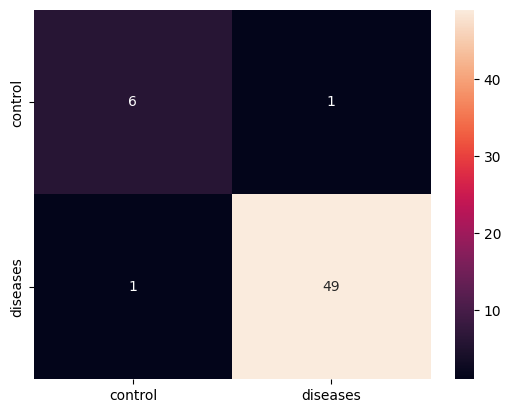

In [3]:
checkpoint_path="checkpoints/ckp_bin.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Bin()
checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint_dict['net'])
model.to(device)

y_pred_list = []

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


test_dataset = ClassifierDataset(torch.from_numpy(x_test_bin).float(), torch.from_numpy(y_test_bin).long())

testloader = DataLoader(dataset=test_dataset, batch_size=1)

with torch.no_grad():
    model.eval()
    for X_batch, _ in testloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(f'Accuracy five: {accuracy_score(y_test_bin, y_pred_list)}')

f1 = f1_score(y_test_bin, y_pred_list, average='macro')
print(f'F1 score five: {f1}')
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_bin, y_pred_list)).rename(columns=idx2classBin, index=idx2classBin)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_bin, y_pred_list))

Accuracy five: 0.75
F1 score five: 0.7448728773806172
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.88      0.78      0.82         9
           2       0.70      0.78      0.74         9
           3       0.83      1.00      0.91        10
           4       0.71      0.50      0.59        10

    accuracy                           0.75        48
   macro avg       0.75      0.75      0.74        48
weighted avg       0.75      0.75      0.74        48



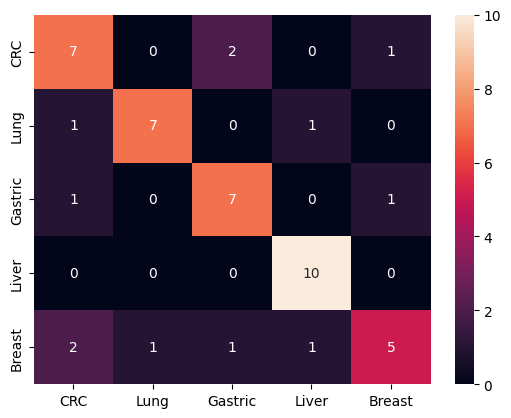

In [4]:
checkpoint_path="checkpoints/ckp_five.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Five()
checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint_dict['net'])
model.to(device)

y_pred_list = []

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


test_dataset = ClassifierDataset(torch.from_numpy(x_test_five).float(), torch.from_numpy(y_test_five).long())

testloader = DataLoader(dataset=test_dataset, batch_size=1)

with torch.no_grad():
    model.eval()
    for X_batch, _ in testloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(f'Accuracy five: {accuracy_score(y_test_five, y_pred_list)}')

f1 = f1_score(y_test_five, y_pred_list, average='macro')
print(f'F1 score five: {f1}')
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_five, y_pred_list)).rename(columns=idx2classFive, index=idx2classFive)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_five, y_pred_list))

# Machine Learning

In [5]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

In [6]:
# load the model from disk
filename = 'checkpoints/ml_svm_bin.sav'
svm_bin = pickle.load(open(filename, 'rb'))
filename = 'checkpoints/ml_rf_bin.sav'
rf_bin = pickle.load(open(filename, 'rb'))
filename = 'checkpoints/ml_knn_bin.sav'
knn_bin = pickle.load(open(filename, 'rb'))

filename = 'checkpoints/ml_svm_five.sav'
svm_five = pickle.load(open(filename, 'rb'))
filename = 'checkpoints/ml_rf_five.sav'
rf_five = pickle.load(open(filename, 'rb'))
filename = 'checkpoints/ml_knn_five.sav'
knn_five = pickle.load(open(filename, 'rb'))

class2idxBin = {
    "control":0,
    "diseases":1,
}

idx2classBin = {v: k for k, v in class2idxBin.items()}

class2idxFive = {
    "CRC":0,
    "Lung":1,
    "Gastric":2,
    "Liver":3,
    "Breast":4
}

idx2classFive = {v: k for k, v in class2idxFive.items()}

class2idxSix = {
    "CRC":0,
    "Control":1,
    "Lung":2,
    "Gastric":3,
    "Liver":4,
    "Breast":5
}

idx2classSix = {v: k for k, v in class2idxSix.items()}

testloader = []

with open('data/val_bin.npy', 'rb') as f:
    x_test0 = np.load(f)
with open('data/val_bin_target.npy', 'rb') as f:
    y_test0 = np.load(f)

with open('data/test_bin.npy', 'rb') as f:
    x_test1 = np.load(f)
with open('data/test_bin_target.npy', 'rb') as f:
    y_test1 = np.load(f)

x_test_bin = np.concatenate([x_test0, x_test1])
y_test_bin = np.concatenate([y_test0, y_test1])

with open('data/val_five.npy', 'rb') as f:
    x_test0 = np.load(f)
with open('data/val_five_target.npy', 'rb') as f:
    y_test0 = np.load(f)

with open('data/test_five.npy', 'rb') as f:
    x_test1 = np.load(f)
with open('data/test_five_target.npy', 'rb') as f:
    y_test1 = np.load(f)

x_test_five = np.concatenate([x_test0, x_test1])
y_test_five = np.concatenate([y_test0, y_test1])

x_test = x_test_five.copy()
y_test = y_test_five.copy()
for i,v in enumerate(y_test_five):
    if v > 0:
        y_test[i] += 1

for i,v in enumerate(y_test_bin):
    if v == 0:
        np.vstack([x_test, x_test_bin[i]])
        y_test = np.append(y_test, 1)

randomize = np.arange(len(x_test))
np.random.shuffle(randomize)
x_test = x_test[randomize]
y_test = y_test[randomize]

Accuracy SVM bin: 0.8947368421052632
F1 score SVM bin: 0.7205882352941176
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.92      0.96      0.94        50

    accuracy                           0.89        57
   macro avg       0.76      0.69      0.72        57
weighted avg       0.88      0.89      0.89        57



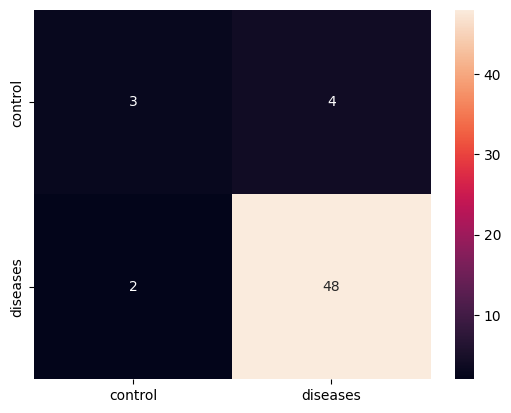

In [7]:
print(f'Accuracy SVM bin: {accuracy_score(y_test_bin, svm_bin.predict(x_test_bin))}')

f1_svm = f1_score(y_test_bin, svm_bin.predict(x_test_bin), average='macro')
print(f'F1 score SVM bin: {f1_svm}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_bin, svm_bin.predict(x_test_bin))).rename(columns=idx2classBin, index=idx2classBin)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_bin, svm_bin.predict(x_test_bin)))

Accuracy SVM five: 0.7083333333333334
F1 score SVM five: 0.7039628482972136
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.64      0.78      0.70         9
           2       0.62      0.56      0.59         9
           3       0.90      0.90      0.90        10
           4       0.70      0.70      0.70        10

    accuracy                           0.71        48
   macro avg       0.71      0.71      0.70        48
weighted avg       0.71      0.71      0.71        48



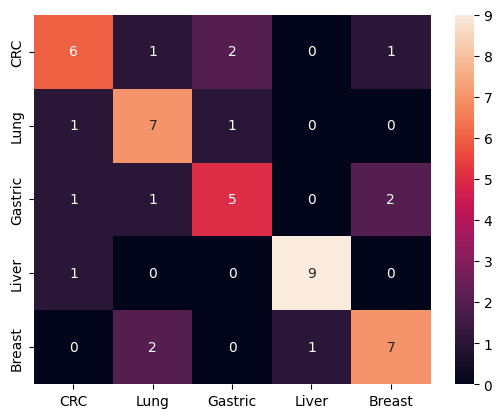

In [8]:
print(f'Accuracy SVM five: {accuracy_score(y_test_five, svm_five.predict(x_test_five))}')

f1_svm = f1_score(y_test_five, svm_five.predict(x_test_five), average='macro')
print(f'F1 score SVM five: {f1_svm}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_five, svm_five.predict(x_test_five))).rename(columns=idx2classFive, index=idx2classFive)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_five, svm_five.predict(x_test_five)))

Accuracy random forest bin: 0.8947368421052632
F1 score random forest bin: 0.7205882352941176
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.92      0.96      0.94        50

    accuracy                           0.89        57
   macro avg       0.76      0.69      0.72        57
weighted avg       0.88      0.89      0.89        57



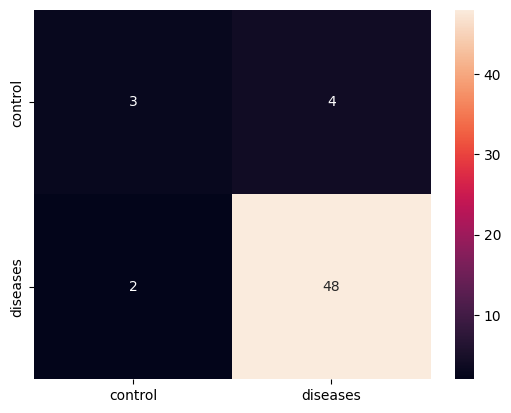

In [9]:
print(f'Accuracy random forest bin: {accuracy_score(y_test_bin, rf_bin.predict(x_test_bin))}')

f1_rf = f1_score(y_test_bin, rf_bin.predict(x_test_bin), average='macro')
print(f'F1 score random forest bin: {f1_rf}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_bin, rf_bin.predict(x_test_bin))).rename(columns=idx2classBin, index=idx2classBin)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_bin, rf_bin.predict(x_test_bin)))

Accuracy random forest five: 0.7083333333333334
F1 score random forest five: 0.7039628482972136
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.64      0.78      0.70         9
           2       0.62      0.56      0.59         9
           3       0.90      0.90      0.90        10
           4       0.70      0.70      0.70        10

    accuracy                           0.71        48
   macro avg       0.71      0.71      0.70        48
weighted avg       0.71      0.71      0.71        48



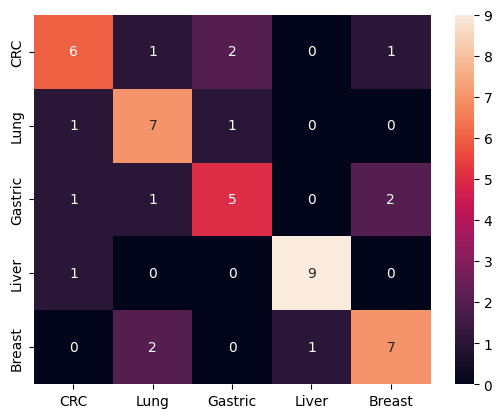

In [10]:
print(f'Accuracy random forest five: {accuracy_score(y_test_five, rf_five.predict(x_test_five))}')

f1_rf = f1_score(y_test_five, rf_five.predict(x_test_five), average='macro')
print(f'F1 score random forest five: {f1_rf}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_five, rf_five.predict(x_test_five))).rename(columns=idx2classFive, index=idx2classFive)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_five, rf_five.predict(x_test_five)))

Accuracy KNN bin: 0.8947368421052632
F1 score KNN bin: 0.7205882352941176
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.92      0.96      0.94        50

    accuracy                           0.89        57
   macro avg       0.76      0.69      0.72        57
weighted avg       0.88      0.89      0.89        57



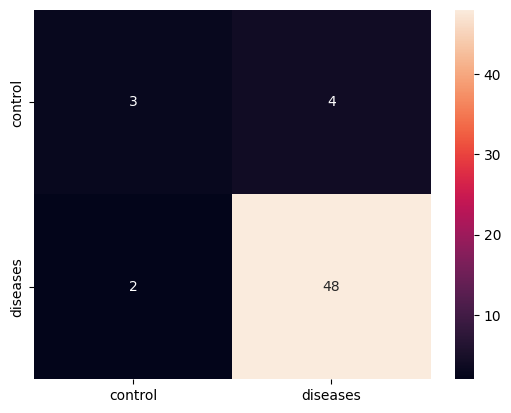

In [11]:
print(f'Accuracy KNN bin: {accuracy_score(y_test_bin, knn_bin.predict(x_test_bin))}')

f1_knn = f1_score(y_test_bin, knn_bin.predict(x_test_bin), average='macro')
print(f'F1 score KNN bin: {f1_knn}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_bin, knn_bin.predict(x_test_bin))).rename(columns=idx2classBin, index=idx2classBin)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_bin, knn_bin.predict(x_test_bin)))

Accuracy KNN five: 0.7083333333333334
F1 score KNN five: 0.7039628482972136
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.64      0.78      0.70         9
           2       0.62      0.56      0.59         9
           3       0.90      0.90      0.90        10
           4       0.70      0.70      0.70        10

    accuracy                           0.71        48
   macro avg       0.71      0.71      0.70        48
weighted avg       0.71      0.71      0.71        48



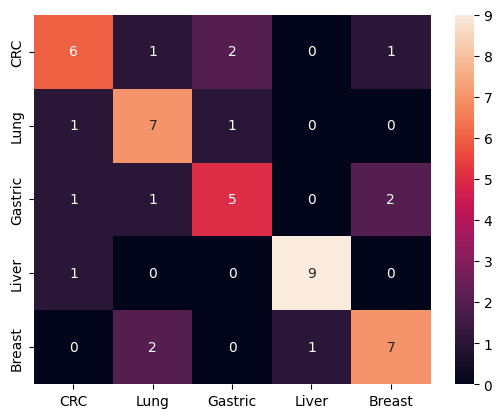

In [12]:
print(f'Accuracy KNN five: {accuracy_score(y_test_five, knn_five.predict(x_test_five))}')

f1_svm = f1_score(y_test_five, knn_five.predict(x_test_five), average='macro')
print(f'F1 score KNN five: {f1_svm}')

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_five, knn_five.predict(x_test_five))).rename(columns=idx2classFive, index=idx2classFive)
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test_five, knn_five.predict(x_test_five)))